<a href="https://colab.research.google.com/github/dipakexe/FINAL_YEAR_PROJECT_2023/blob/main/notebooks/lung_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lungs Disease Detection 🫁**

**INDEX**

- [DATA COLLECTION](#data-collection)
- [DATA PRE-PROCESSING](#data-pre-processing)
- [MODEL BUILDING](#model-building)
- [MODEL EVALUATION](#model-evaluation)
- [CONCLUSION](#conclusion)

### IMPORTING REQUIRED LIBRARIES

In [1]:
import warnings
warnings.filterwarnings("ignore")

# FOR DATA MANIPULATION AND VISUALIZATION
import numpy as np
import matplotlib.pyplot as plt

# FOR MODEL BUILDING
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# FOR MODEL EVALUATION
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

<a name="data-collection"></a>
## **DATA COLLECTION**

## DATA SOURCE

We're considering two datasets to use to achieve our goal. We can use either one of them or both as required. Anyone can find these datasets on Kaggle. These datasets have pictures with labels showing whether **they're x-rays of lungs with pneumonia or normal lungs.**

1. [Lungs Disease Dataset (4 types) - Chest X-Rays of Viral Pneumonia, Bacterial Pneumonia, Covid and Tuberculosis](https://www.kaggle.com/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types).
2. [Chest X-ray Images - for pneumonia detection with deep learning](https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images)

Currently, we are utilizing the second option, focusing solely on **two image classes: normal X-rays and those depicting pneumonia**. The first option can also serve our purpose by excluding any additional image classes.

## DOWNLOADING THE DATA FROM KAGGLE

In [2]:
import os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
os.environ['KAGGLE_CONFIG_DIR'] = os.path.dirname('/content/drive/MyDrive/Colab Notebooks/kaggle.json')

Mounted at /content/drive


In [3]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

 98% 1.15G/1.17G [00:09<00:00, 27.5MB/s]
100% 1.17G/1.17G [00:10<00:00, 125MB/s] 


In [4]:
!mkdir -p data/extracted_data/
!unzip -qn /content/labeled-chest-xray-images.zip -d data/extracted_data/

<a name="data-pre-processing"></a>
## **DATA PRE-PROCESSING**

### LOADING THE DATASET

In [5]:
batch_size = 64
img_size = (224, 224)

In [6]:
extracted_dataset_path = "data/extracted_data/chest_xray/"

train_dir = os.path.join(extracted_dataset_path, 'train')
val_dir = os.path.join(extracted_dataset_path, 'val')
test_dir = os.path.join(extracted_dataset_path, 'test')

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    channel_shift_range=50.0,
    horizontal_flip=True,
    validation_split=0.4
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.4)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 3140 images belonging to 2 classes.
Found 2092 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


<a name='model-building'></a>
## **MODEL BUILDING**

In [52]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential(name="lung_disease_detection_model")
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

model.summary()

Model: "lung_disease_detection_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
 1 (GlobalAveragePooling2D)                                      
                                                                 
 dense_22 (Dense)            (None, 512)               524800    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_23 (Dense)            (None, 1)                 513       
                                                                 
Total params: 7562817 (28.85 MB)
Trainable params: 525313 (2.00 MB)
Non-trainable params: 7037504 (26.85

In [53]:
checkpoint = ModelCheckpoint(
    'tmp/best_model',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',  # 'max' for accuracy and 'min' for loss
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=1,
    verbose=1
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/10
49/49 [==============================] - ETA: 0s - loss: 0.4077 - accuracy: 0.8088 - recall: 0.9369
Epoch 1: val_accuracy improved from -inf to 0.91064, saving model to tmp/best_model
49/49 [==============================] - 155s 3s/step - loss: 0.4077 - accuracy: 0.8088 - recall: 0.9369 - val_loss: 0.2753 - val_accuracy: 0.9106 - val_recall: 0.9124 - lr: 1.0000e-04
Epoch 2/10
49/49 [==============================] - ETA: 0s - loss: 0.3024 - accuracy: 0.8709 - recall: 0.9364
Epoch 2: val_accuracy did not improve from 0.91064

Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
49/49 [==============================] - 99s 2s/step - loss: 0.3024 - accuracy: 0.8709 - recall: 0.9364 - val_loss: 0.2769 - val_accuracy: 0.8945 - val_recall: 0.8708 - lr: 1.0000e-04
Epoch 3/10
49/49 [==============================] - ETA: 0s - loss: 0.2753 - accuracy: 0.8878 - recall: 0.9338
Epoch 3: val_accuracy improved from 0.91064 to 0.91455, saving model to tmp/best_model

Unlike fine-tuning, In transfer learning we use a pretrained model (here DenseNet121) as feature extraction layer.

<a name='model-evaluation'></a>
## **MODEL EVALUATION**

### EVALUATION METRICS

We are using recall (or sensitivity) as the evaluation metrics. It is ability of the model to correctly identify positive cases out of all actual positive cases. **Recall = TP / (TP + FN)**. In disease detection, missing a positive case (false negative) can have serious consequences as it means not identifying a patient who actually has the disease. Therefore, a high recall is crucial to minimize false negatives.

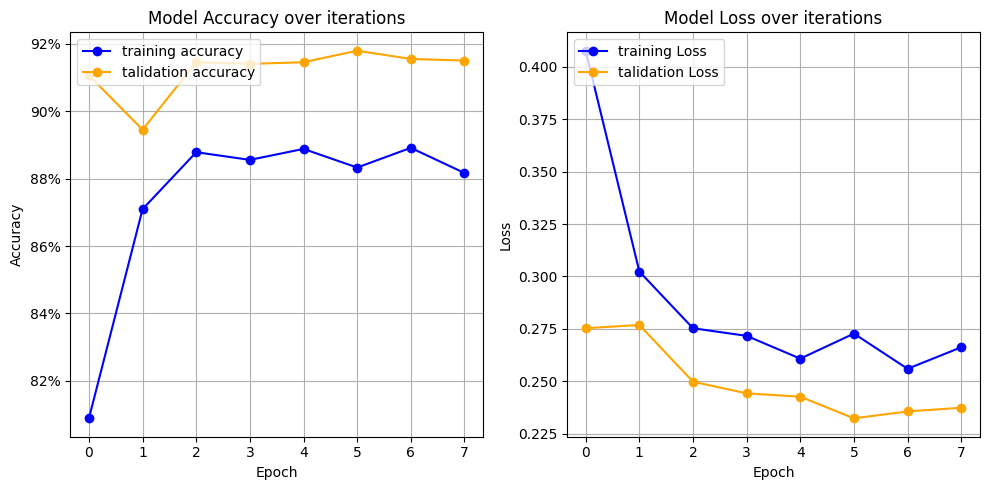

In [54]:
# Plotting the learning curves
plt.figure(figsize=(10, 5))

# The training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='training accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='talidation accuracy', color='orange', marker='o')
plt.title('Model Accuracy over iterations')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.grid(True)

# The training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='training Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='talidation Loss', color='orange', marker='o')
plt.title('Model Loss over iterations')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

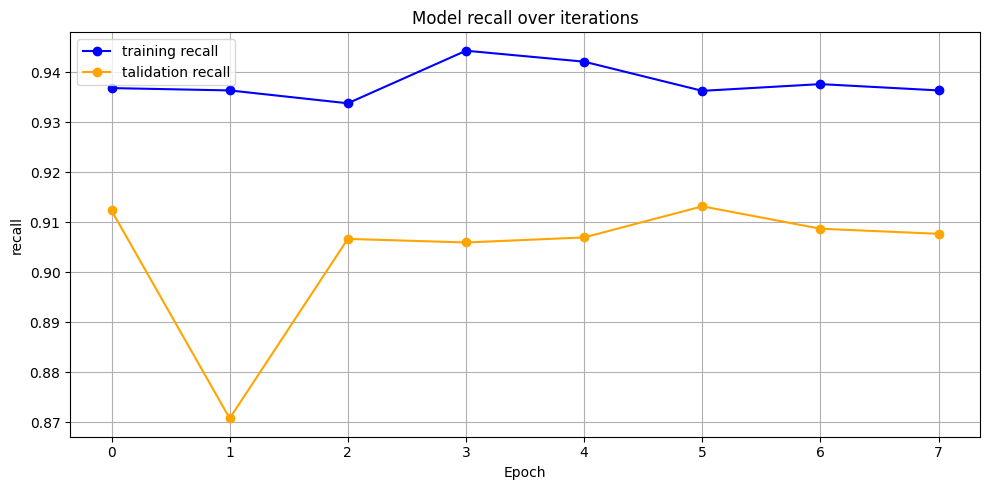

In [58]:
# Plotting the training and validation recall
plt.figure(figsize=(10, 5))

plt.plot(history.history['recall'], label='training recall', color='blue', marker='o')
plt.plot(history.history['val_recall'], label='talidation recall', color='orange', marker='o')
plt.title('Model recall over iterations')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

### ACCURACY ON TEST SET

In [56]:
test_loss, test_accuracy, recall = model.evaluate(test_generator, steps=test_generator.samples // batch_size, verbose=0)
print(f'Accuracy on test set: {test_accuracy * 100:.2f}%')

Accuracy on test set: 88.54%


<a name='conclusion'></a>
## **CONCLUSION**

we are saving the model weights for future applications.

In [57]:
model.save('/content/drive/MyDrive/Colab Notebooks/models/FINAL_YEAR_PROJECT_2023/lung_disease_model.keras')